In [1]:
from gensim.models.word2vec import Word2Vec # make use of pretrained embeddings
from keras.preprocessing import sequence
from keras.utils import np_utils # for converting labels vectors to matrices in multi-class cases
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.callbacks import EarlyStopping
from evaluate import compute_performance, compute_performance_from_df
import numpy as np

np.random.seed(42)  # for reproducibility

%load_ext autoreload
%autoreload 2

Using Theano backend.


# Load data

In [33]:
import pandas as pd

data = pd.read_json("../annotations.json")

# how many annotations exist with the positive labels of interest?
print("annotations for E1 precedes E2: {}".format((pd.read_json("../annotations.json").relation == "E1 precedes E2").sum()))
print("annotations for E2 precedes E1: {}".format((pd.read_json("../annotations.json").relation == "E2 precedes E1").sum()))

# filter out bugs and empty relations
data = data[(data.relation != "Bug") & (data.relation != "")]

# set labels other than precedence to "None"
label_to_value = {
    'E1 precedes E2': 1,
    'E2 precedes E1': 2,
    'None': 0,
    'E1 subsumes E2': 0, 
    'E2 subsumes E1': 0, 
    'Equivalent': 0, 
    'Other': 0
}

# value -> label
value_to_label = {v:k for (k,v) in label_to_value.items() if k in {"E1 precedes E2", "E2 precedes E1", "None"}}

data.relation = data.relation.replace(label_to_value)
# we should now have only three kinds of labels in our relation annotations
assert len(set(data.relation.values)) == 3
print("Value -> Class: {}".format(value_to_label))

# TODO: split the data evenly among classes (training, dev, and test)
# TODO: perform 5-fold cross validation with where each fold has the the three classes represented
# text as input
x = data.text.values
# relations as labels
y = data.relation.values

annotations for E1 precedes E2: 123
annotations for E2 precedes E1: 16
Value -> Class: {0: 'None', 1: 'E1 precedes E2', 2: 'E2 precedes E1'}


## Prepare the tokenizer

In [3]:
from keras.preprocessing.text import one_hot, base_filter, Tokenizer

# remove numbers, punct (except for _), etc.
custom_filter = "!#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789'" 
print(custom_filter)
tk = Tokenizer(
    # the maximum num. of words to retain
    nb_words=None,
    # the characters to filter out from the text
    filters=custom_filter,
    # whether or not to convert the text to lowercase
    lower=True,
    # the character to split on
    split=" ",
    # whether or not to treat each character as a word
    char_level=False
)

!#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789'


Index the text

In [4]:
tk.fit_on_texts(x)
#one_hot(text, n, filters=base_filter(), lower=True, split=" ")

Convert the text into sequences of term indices

In [5]:
x = tk.texts_to_sequences(x)

Pad the sequences

In [6]:
###################################
# the maximum size of a sequence
max_len = 200

x = sequence.pad_sequences(x, maxlen=max_len)

In [7]:
from gensim.models.word2vec import Word2Vec

w2v_data = "../pmc-openaccess-w2v.bin"
def create_embeddings_weights(w2v_vectors_file, tokenizer):
    word2index = tk.word_index
    # reverse index
    index2word = {i:w for (w,i) in tk.word_index.items()}
    max_size = len(index2word) + 1
    # load w2v model
    w2v = Word2Vec.load_word2vec_format(w2v_vectors_file, binary=True)
    word_vector_dims = w2v.vector_size
    embedding_weights = np.zeros((max_size, word_vector_dims))
    
    for i,w in index2word.items():
        try:
            embedding_weights[i,:] = w2v[w]
        except:
            print("{} not found".format(w))
    return (w2v, embedding_weights)


# Using pretrained word embeddings

We can initialize our network with pretrained word embeddings.  Here, we use embeddings generated using a `word2vec` model that was trained on the open access subset of PubMed retrieved in **????**, which contains over a million (**TODO: get exact number**) papers.  

In preparing the text for `word2vec`, we chose to ignore the following sections in the `nxml` files: "references", "materials", "methods", and "supplementary-material".

In [8]:
# get pretrained embeddings from w2v model
(w2v, pretrained_weights) = create_embeddings_weights(w2v_data, tk)

" not found
atmmutation not found
kgamma not found
gammah not found
piasgamma not found
pkczetaii not found
ralas not found
raswt not found
ikappak not found
gigoux not found
gresko not found
deltarbd not found
tovok not found
hamamori not found


### Example of word vector similarity

In [9]:
w2v.most_similar(positive=['telomerase'])

[('htert', 0.715091347694397),
 ('tert', 0.7061598300933838),
 ('wrn', 0.614983320236206),
 ('dnmt', 0.6079218983650208),
 ('recql', 0.6020419597625732),
 ('telomere', 0.596019446849823),
 ('trf', 0.5914173126220703),
 ('dnapkcs', 0.5826644897460938),
 ('cdk', 0.5765817761421204),
 ('dyskerin', 0.5567993521690369)]

## Set layer dimensions

In [10]:
# the maximum number of features to retain
max_features = len(tk.word_index) + 1 # for mask
print("Max features: {}".format(max_features))

# the number of samples to use for one update
batch_size = 32
# 
hidden_size = w2v.vector_size

Max features: 2990


# Prepare classes

We have 3 possible labels ("E1 precedes E2", "E2 precedes E1", or "None"), so we need to convert our length-normalized class label vectors to matrices of size $n$ classes.

**Important**: _if you don't do this, the model will not learn!_

In [11]:
num_classes = 3

# convert class vectors to binary class matrices
y = np_utils.to_categorical(y, num_classes)

## Prepare the model

In [12]:
model = Sequential()

# build the embeddings layer
embeddings = Embedding(
    input_dim=max_features, 
    output_dim=hidden_size, 
    input_length=max_len, 
    W_regularizer=None,
    #weights=None,
    # use pretrained vectors
    weights=[pretrained_weights],
    dropout=0.2
)
model.add(embeddings)
# build the lstm layer
lstm = LSTM(
    #input_dim=max_features,
    output_dim=hidden_size, 
    dropout_W=0.2, 
    dropout_U=0.2, 
    return_sequences=False
)
model.add(lstm)
model.add(Dropout(0.5))
# size should be equal to the number of classes
model.add(Dense(num_classes))
# at the end of the day, we only want one label per input (hence softmax)
model.add(Activation('softmax'))

# add early stopping to help avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=["accuracy"]
)

history = model.fit(
    # input
    x, 
    # target labels
    y=y, 
    # how many examples to consider at once
    batch_size=batch_size, 
    # the number of epochs to train
    nb_epoch=8,
    # 0 for no logging, 1 for progress bar logging, 2 for one log line per epoch
    verbose=1,
    # the validation data to use,
    #validation_data=(x_dev, y_dev),
    # how much data to reserve for validation (takes n% starting at the end of the dataset)
    validation_split=0.2,
    # should the training data be shuffled?
    shuffle=True,
    # dict mapping classes to weight for scaling in loss function
    class_weight=None,
    callbacks=[early_stopping]
)

Train on 780 samples, validate on 156 samples
Epoch 1/8
780/780 [==============================] - 20s - loss: 0.6581 - acc: 0.7769 - val_loss: 0.3256 - val_acc: 0.8910
Epoch 2/8
780/780 [==============================] - 20s - loss: 0.4914 - acc: 0.8256 - val_loss: 0.2736 - val_acc: 0.8846
Epoch 3/8
780/780 [==============================] - 22s - loss: 0.4543 - acc: 0.8333 - val_loss: 0.2354 - val_acc: 0.9038
Epoch 4/8
780/780 [==============================] - 19s - loss: 0.4175 - acc: 0.8397 - val_loss: 0.2179 - val_acc: 0.9359
Epoch 5/8
780/780 [==============================] - 19s - loss: 0.4083 - acc: 0.8333 - val_loss: 0.1970 - val_acc: 0.9167
Epoch 6/8
780/780 [==============================] - 21s - loss: 0.3490 - acc: 0.8551 - val_loss: 0.1881 - val_acc: 0.9167
Epoch 7/8
780/780 [==============================] - 19s - loss: 0.3348 - acc: 0.8615 - val_loss: 0.1553 - val_acc: 0.9295
Epoch 8/8
780/780 [==============================] - 18s - loss: 0.3306 - acc: 0.8692 - val_l

In [13]:
performance = model.evaluate(x, y, batch_size=batch_size, verbose=0)
loss, accuracy = performance[0], performance[-1]
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.231070866417
Test accuracy: 0.887179487485


## Model architecture

We can display a simple graph of the network's architecture using `dot`.

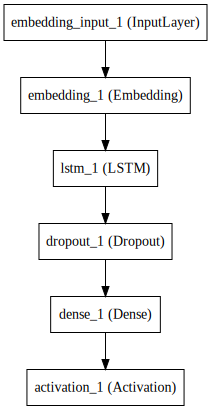

In [14]:
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# from keras.utils.visualize_util import plot
# plot(model, to_file='model.png')
# plot(model)

# Compare `LSTM` to classifier's performance

In [15]:
predictions = model.predict_classes(x, batch_size=batch_size, verbose=0)

In [36]:
def convert_predictions(predictions):
    """
    converts values in a numpy array to their corresponding label
    """
    label_LUT = {
        0:"None",
        1:"E1 precedes E2",
        2:"E2 precedes E1"
    }
    for p in predictions:
        yield label_LUT.get(p, "None")
        
def get_gold_labels(annotations_path):
    data = pd.read_json(annotations_path)
    # filter out bugs and empty relations
    data = data[(data.relation != "Bug") & (data.relation != "")]
    data.relation = data.relation.replace(label_to_value)
    data.relation = data.relation.replace(value_to_label)
    return data.relation.values
            
new_preds = list(convert_predictions(predictions))
gold = get_gold_labels("../annotations.json")

In [37]:
classifier_performance = compute_performance("results.tsv")

print("Classifier performance")
print(classifier_performance.round(2))
print()

lstm_performance = compute_performance_from_df(pd.DataFrame({'Gold':gold, 'Predicted':new_preds}))

print("LSTM performance (with pretrained embeddings)")
print(lstm_performance.round(2))
print()


Classifier performance
                                Class  Precision  Recall    F1  Support
0                      E1 precedes E2       0.13    0.37  0.19      122
1                      E2 precedes E1       0.00    0.00  0.00       16
2                                None       0.79    0.53  0.63      641
3  TOTAL (macro for positive classes)       0.06    0.18  0.10      138

LSTM performance (with pretrained embeddings)
                                Class  Precision  Recall    F1  Support
0                      E1 precedes E2       0.98    0.37  0.53      123
1                      E2 precedes E1       1.00    0.37  0.55       16
2                                None       0.88    1.00  0.93      641
3  TOTAL (macro for positive classes)       0.99    0.37  0.54      139



In [19]:
# from sklearn.cross_validation import StratifiedKFold

# def load_data():
#     # load your data using this function

# def create model():
#     # create your model using this function

# def train_and_evaluate__model(model, data[train], labels[train], data[test], labels[test)):
#     model.fit...
#     # fit and evaluate here.

# if __name__ == "__main__":
#     n_folds = 10
#     data, labels, header_info = load_data()
#     skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

#     for i, (train, test) in enumerate(skf):
#             print "Running Fold", i+1, "/", n_folds
#             model = None # Clearing the NN.
#             model = create_model()
#             train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test))